1. Setup

In [7]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import os
import pickle
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Model training

In [8]:

def load_batch(file_path):
    with open(file_path, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    data = batch[b'data']
    labels = batch[b'labels']
    data = data.reshape(-1, 3, 32, 32).astype(np.uint8)  # trans to 32x32x3 size
    return data, labels

def load_cifar10_data(data_dir):
    train_data, train_labels = [], []

    for i in range(1, 6):
        batch_file = os.path.join(data_dir, f'data_batch_{i}')
        data, labels = load_batch(batch_file)
        train_data.append(data)
        train_labels.extend(labels)

    # combine
    train_data = np.concatenate(train_data)
    train_labels = np.array(train_labels)

    # load test data
    test_data, test_labels = load_batch(os.path.join(data_dir, 'test_batch'))
    test_labels = np.array(test_labels)

    return train_data, train_labels, test_data, test_labels

class CIFAR10Dataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # trans img size to 32x32x3
        image = self.data[idx].reshape(3, 32, 32)
        image = image.transpose((1, 2, 0))

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
os.chdir('/content/drive/MyDrive/code/dataset')
# data_dir = "C:/Users/star/Desktop/deeplearning/code/dataset/cifar-10-batches-py"
data_dir = "cifar-10-batches-py"
train_data, train_labels, test_data, test_labels = load_cifar10_data(data_dir)

# Create CIFAR-10 dataset for training, validation, and testing
full_train_dataset = CIFAR10Dataset(train_data, train_labels, transform=transform)
test_dataset = CIFAR10Dataset(test_data, test_labels, transform=transform)

# Split full training data into training and validation sets
train_indices, val_indices = train_test_split(
    list(range(len(full_train_dataset))), test_size=0.2, random_state=42
)
train_subset = Subset(full_train_dataset, train_indices)
val_subset = Subset(full_train_dataset, val_indices)

# Create DataLoader for training, validation, and test sets
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [13]:
print(len(full_train_dataset))
print(len(test_dataset))

50000
10000


In [ ]:
model = models.alexnet(pretrained=False)
model.classifier[6] = nn.Linear(4096, 10)
model.to(device)

# model = models.resnet18(pretrained=False)
# model.fc = nn.Linear(model.fc.in_features, 10)  # CIFAR-10 has 10 feature classes
# model = model.to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# train model
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).long()

            # forward
            outputs = model(images)
            loss = criterion(outputs, labels)

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # get loss and accuracy
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / total
        accuracy = correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")

train_model(model, train_loader, criterion, optimizer, num_epochs=30)

model_save_path = "mobienet_cifar10_Adam_epoch30_lr001.pth"
torch.save(model.state_dict(), model_save_path)
print(f"model saved")

In [14]:
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)  # CIFAR-10 has 10 classes
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=30):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / total
        accuracy = correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")

# Train MobileNetV2
train_model(model, train_loader, criterion, optimizer, num_epochs=30)

# Save the trained model
model_save_path = "mobilenetv2_cifar10_epoch30_lr001.pth"
torch.save(model.state_dict(), model_save_path)
print("Model saved")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/30], Loss: 1.4508, Accuracy: 0.4650
Epoch [2/30], Loss: 0.9828, Accuracy: 0.6532
Epoch [3/30], Loss: 0.7698, Accuracy: 0.7312
Epoch [4/30], Loss: 0.6415, Accuracy: 0.7778
Epoch [5/30], Loss: 0.5676, Accuracy: 0.8054
Epoch [6/30], Loss: 0.5094, Accuracy: 0.8228
Epoch [7/30], Loss: 0.4605, Accuracy: 0.8427
Epoch [8/30], Loss: 0.4244, Accuracy: 0.8537
Epoch [9/30], Loss: 0.3863, Accuracy: 0.8651
Epoch [10/30], Loss: 0.3599, Accuracy: 0.8755
Epoch [11/30], Loss: 0.3317, Accuracy: 0.8846
Epoch [12/30], Loss: 0.3086, Accuracy: 0.8912
Epoch [13/30], Loss: 0.2868, Accuracy: 0.8994
Epoch [14/30], Loss: 0.2698, Accuracy: 0.9072
Epoch [15/30], Loss: 0.2453, Accuracy: 0.9141
Epoch [16/30], Loss: 0.2336, Accuracy: 0.9180
Epoch [17/30], Loss: 0.2186, Accuracy: 0.9242
Epoch [18/30], Loss: 0.2031, Accuracy: 0.9282
Epoch [19/30], Loss: 0.1968, Accuracy: 0.9306
Epoch [20/30], Loss: 0.1793, Accuracy: 0.9366
Epoch [21/30], Loss: 0.1670, Accuracy: 0.9414
Epoch [22/30], Loss: 0.1599, Accuracy: 0.94

In [4]:

# ResNet-18 model setup
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=30):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        epoch_loss = running_loss / total
        accuracy = correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")

# Train ResNet-18
train_model(model, train_loader, criterion, optimizer, num_epochs=30)

# Save the trained model
model_save_path = "resnet18_cifar10_epoch30_lr001.pth"
torch.save(model.state_dict(), model_save_path)
print("Model saved")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/30], Loss: 1.3577, Accuracy: 0.5065
Epoch [2/30], Loss: 0.8433, Accuracy: 0.7017
Epoch [3/30], Loss: 0.6500, Accuracy: 0.7717
Epoch [4/30], Loss: 0.5386, Accuracy: 0.8126
Epoch [5/30], Loss: 0.4618, Accuracy: 0.8398
Epoch [6/30], Loss: 0.4045, Accuracy: 0.8582
Epoch [7/30], Loss: 0.3519, Accuracy: 0.8780
Epoch [8/30], Loss: 0.3112, Accuracy: 0.8936
Epoch [9/30], Loss: 0.2724, Accuracy: 0.9052
Epoch [10/30], Loss: 0.2388, Accuracy: 0.9154
Epoch [11/30], Loss: 0.2074, Accuracy: 0.9277
Epoch [12/30], Loss: 0.1783, Accuracy: 0.9374
Epoch [13/30], Loss: 0.1603, Accuracy: 0.9426
Epoch [14/30], Loss: 0.1417, Accuracy: 0.9489
Epoch [15/30], Loss: 0.1195, Accuracy: 0.9571
Epoch [16/30], Loss: 0.1061, Accuracy: 0.9628
Epoch [17/30], Loss: 0.0974, Accuracy: 0.9657
Epoch [18/30], Loss: 0.0870, Accuracy: 0.9702
Epoch [19/30], Loss: 0.0812, Accuracy: 0.9716
Epoch [20/30], Loss: 0.0693, Accuracy: 0.9750
Epoch [21/30], Loss: 0.0678, Accuracy: 0.9762
Epoch [22/30], Loss: 0.0614, Accuracy: 0.97

In [5]:
model_load_path = "resnet18_cifar10_epoch30_lr001.pth"
model.load_state_dict(torch.load(model_load_path))
print("Model loaded successfully.")

# Set the model to evaluation mode
model.eval()

# Evaluation function
def evaluate_model(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient computation for evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

# Evaluate the model on the test dataset
evaluate_model(model, test_loader)

<ipython-input-5-83fbdbdd06aa>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path))


Model loaded successfully.
Test Accuracy: 0.8907


Evaluation

In [9]:
# Modify training code to save metrics per epoch
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30):
    model.train()
    training_loss = []
    validation_loss = []
    training_accuracy = []
    validation_accuracy = []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / total
        accuracy = correct / total
        training_loss.append(epoch_loss)
        training_accuracy.append(accuracy)

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_epoch_loss = val_loss / val_total
        val_accuracy = val_correct / val_total
        validation_loss.append(val_epoch_loss)
        validation_accuracy.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}, "
              f"Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return training_loss, training_accuracy, validation_loss, validation_accuracy

# Plotting training and validation curves
def plot_learning_curves(training_loss, validation_loss, training_accuracy, validation_accuracy):
    epochs = range(1, len(training_loss) + 1)

    # Loss curves
    plt.figure()
    plt.plot(epochs, training_loss, label="Training Loss")
    plt.plot(epochs, validation_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

    # Accuracy curves
    plt.figure()
    plt.plot(epochs, training_accuracy, label="Training Accuracy")
    plt.plot(epochs, validation_accuracy, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.show()

# Loading the saved model and evaluating on the test set
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect labels and predictions for confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(10)])
    display.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix for ResNet-18 on CIFAR-10")
    plt.show()

# Model parameter count
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters in model: {total_params}")

# Main execution (assuming you have trained and saved ResNet-18)
data_dir = "cifar-10-batches-py"  # Adjust this path as necessary
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)  # CIFAR-10 has 10 classes
model = model.to(device)
model.load_state_dict(torch.load("resnet18_cifar10_epoch30_lr001.pth"))
print("Model loaded successfully.")

# Assuming train_loader, val_loader, and test_loader are already defined
# Training and Validation Curves
training_loss, training_accuracy, validation_loss, validation_accuracy = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=30)


<ipython-input-9-2a54fc574bd0>:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("resnet18_cifar10_epoch30_lr001.pth"))


Model loaded successfully.
Epoch [1/30], Loss: 0.0408, Accuracy: 0.9857, Val Loss: 0.0339, Val Accuracy: 0.9884
Epoch [2/30], Loss: 0.0417, Accuracy: 0.9853, Val Loss: 0.0303, Val Accuracy: 0.9885
Epoch [3/30], Loss: 0.0427, Accuracy: 0.9857, Val Loss: 0.0324, Val Accuracy: 0.9879
Epoch [4/30], Loss: 0.0432, Accuracy: 0.9852, Val Loss: 0.0328, Val Accuracy: 0.9883
Epoch [5/30], Loss: 0.0412, Accuracy: 0.9857, Val Loss: 0.0342, Val Accuracy: 0.9876
Epoch [6/30], Loss: 0.0429, Accuracy: 0.9853, Val Loss: 0.0295, Val Accuracy: 0.9896
Epoch [7/30], Loss: 0.0402, Accuracy: 0.9860, Val Loss: 0.0292, Val Accuracy: 0.9892
Epoch [8/30], Loss: 0.0420, Accuracy: 0.9852, Val Loss: 0.0315, Val Accuracy: 0.9892
Epoch [9/30], Loss: 0.0417, Accuracy: 0.9855, Val Loss: 0.0349, Val Accuracy: 0.9868
Epoch [10/30], Loss: 0.0409, Accuracy: 0.9855, Val Loss: 0.0347, Val Accuracy: 0.9885
Epoch [11/30], Loss: 0.0430, Accuracy: 0.9850, Val Loss: 0.0353, Val Accuracy: 0.9877
Epoch [12/30], Loss: 0.0401, Accurac

NameError: name 'plt' is not defined

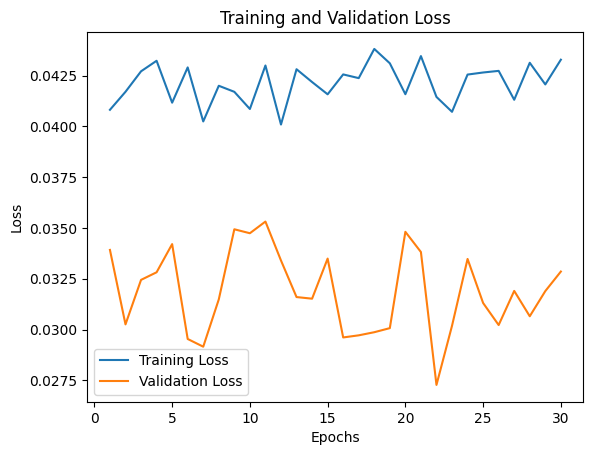

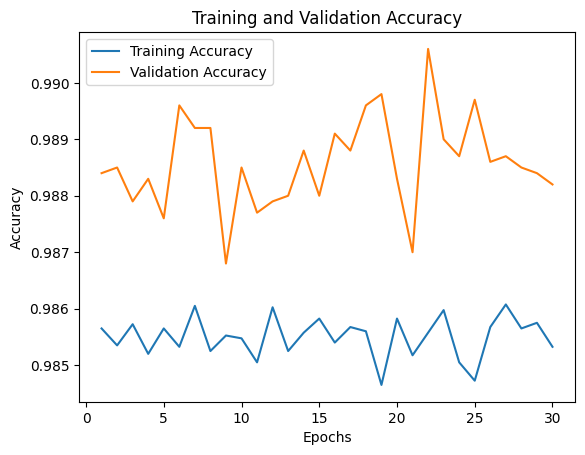

Test Accuracy: 0.8968


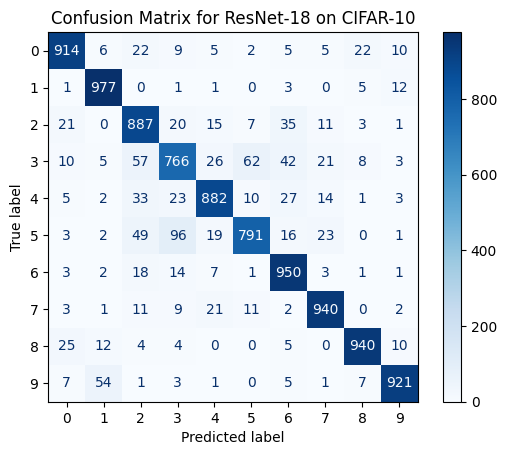

Total trainable parameters in model: 11181642


In [11]:
import matplotlib.pyplot as plt
plot_learning_curves(training_loss, validation_loss, training_accuracy, validation_accuracy)

# Evaluate on Test Set and Generate Confusion Matrix
evaluate_model(model, test_loader)

# Count Model Parameters
count_parameters(model)